In [1]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mizani.formatters import percent_format
from plotnine import *
from datetime import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import norm
from IPython.core.display import HTML
from stargazer.stargazer import Stargazer
import statsmodels.nonparametric.kernel_regression as loess

from mizani.transforms import log_trans
from mizani.formatters import percent_format
from mizani.formatters import log_format

In [2]:
# Read the CSVs into a variable
price_data = pd.read_csv('hotels-europe_price.csv')
features_data = pd.read_csv('hotels-europe_features.csv')

In [3]:
# merge the two datasets with the key 'hotel_id'
merged_hotel_data = pd.merge(price_data, features_data, on='hotel_id')

In [4]:
# convert accommodation_type and city_actual to string so that it can be filtered
merged_hotel_data['accommodation_type'] = merged_hotel_data['accommodation_type'].astype('string')
merged_hotel_data['city_actual']=merged_hotel_data['city'].astype('string')

In [5]:
# Dropping duplicates after merging
# merged_hotel_data = merged_hotel_data.drop_duplicates(subset='hotel_id')

In [6]:
# filter the merged data for Moscow
merged_hotel_data_moscow = merged_hotel_data.loc[(merged_hotel_data["city"].isin(['Moscow']))
                                                  ]
merged_hotel_data_moscow

,hotel_id,price,offer,offer_cat,year,month,weekend,holiday,nnights,scarce_room,...,country,city_actual,rating_reviewcount,center1label,center2label,neighbourhood,ratingta,ratingta_count,distance_alter,accommodation_type
77569,10946,16,0,0% no offer,2018,3,1,0,1,1,...,Russia,Moscow,NaN,City centre,Solntsevo Exhibition Hall,Akademicheskiy,4.0,1.0,7.8,Hostel
77570,10946,16,0,0% no offer,2017,12,0,1,1,1,...,Russia,Moscow,NaN,City centre,Solntsevo Exhibition Hall,Akademicheskiy,4.0,1.0,7.8,Hostel
77571,10946,16,0,0% no offer,2018,5,1,0,1,1,...,Russia,Moscow,NaN,City centre,Solntsevo Exhibition Hall,Akademicheskiy,4.0,1.0,7.8,Hostel
77572,10946,17,0,0% no offer,2017,11,0,0,1,1,...,Russia,Moscow,NaN,City centre,Solntsevo Exhibition Hall,Akademicheskiy,4.0,1.0,7.8,Hostel
77573,10946,64,0,0% no offer,2017,12,0,1,4,1,...,Russia,Moscow,NaN,City centre,Solntsevo Exhibition Hall,Akademicheskiy,4.0,1.0,7.8,Hostel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80922,11345,43,0,0% no offer,2018,4,1,0,1,1,...,Russia,Moscow,NaN,City centre,Solntsevo Exhibition Hall,Yudino,NaN,NaN,8.6,Hotel
80923,11345,43,0,0% no offer,2018,2,1,0,1,1,...,Russia,Moscow,NaN,City centre,Solntsevo Exhibition Hall,Yudino,NaN,NaN,8.6,Hotel
80924,11345,43,0,0% no offer,2018,1,1,0,1,1,...,Russia,Moscow,NaN,City centre,Solntsevo Exhibition Hall,Yudino,NaN,NaN,8.6,Hotel
80925,11345,43,0,0% no offer,2018,3,1,0,1,1,...,Russia,Moscow,NaN,City centre,Solntsevo Exhibition Hall,Yudino,NaN,NaN,8.6,Hotel


### Ratings Data Cleaning

In [7]:
# Step 1: Identify the number of null values in the 'rating' column
null_count = merged_hotel_data_moscow['rating'].isnull().sum()
print(f"Number of null values in the 'rating' column: {null_count}")

Number of null values in the 'rating' column: 792


In [8]:
# Step 2: Transform null values to 0
merged_hotel_data_moscow['rating'].fillna('NULL', inplace=True)

C:\Users\iandr\AppData\Local\Temp\ipykernel_43932\2179072277.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'NULL' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
C:\Users\iandr\AppData\Local\Temp\ipykernel_43932\2179072277.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [9]:
# Optionally, verify the transformation
print(merged_hotel_data_moscow['rating'].isnull().sum())  # Should output 0

0


In [10]:
# Drop rows where 'rating_reviewcount' is 'NULL'
merged_hotel_data_moscow = merged_hotel_data_moscow[merged_hotel_data_moscow['rating'] != 'NULL']

# Optionally, verify the operation
print(f"Number of rows with 'rating' as 'NULL': {len(merged_hotel_data_moscow[merged_hotel_data_moscow['rating'] == 'NULL'])}")

Number of rows with 'rating' as 'NULL': 0


### `rating_reviewcount` cleaning

In [11]:
# Step 1: Identify the number of null values in the 'rating' column
null_count = merged_hotel_data_moscow['rating_reviewcount'].isnull().sum()
print(f"Number of null values in the 'rating' column: {null_count}")

Number of null values in the 'rating' column: 0


In [12]:
# Step 2: Transform null values to 0
merged_hotel_data_moscow['rating_reviewcount'].fillna('NULL', inplace=True)

C:\Users\iandr\AppData\Local\Temp\ipykernel_43932\2439054958.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [13]:
# Optionally, verify the transformation
print(merged_hotel_data_moscow['rating_reviewcount'].isnull().sum())  # Should output 0

0


In [14]:
# Drop rows where 'rating_reviewcount' is 'NULL'
merged_hotel_data_moscow = merged_hotel_data_moscow[merged_hotel_data_moscow['rating_reviewcount'] != 'NULL']

# Optionally, verify the operation
print(f"Number of rows with 'rating_reviewcount' as 'NULL': {len(merged_hotel_data_moscow[merged_hotel_data_moscow['rating_reviewcount'] == 'NULL'])}")

Number of rows with 'rating_reviewcount' as 'NULL': 0


### Create `highly_rated` column

In [15]:
# new column 'highly_rated'
# Set to 1 if 'rating' is greater than or equal to 4, and 0 otherwise
merged_hotel_data_moscow['highly_rated'] = merged_hotel_data_moscow['rating'].apply(lambda x: 1 if x >= 4 else 0)
print(merged_hotel_data_moscow.head())

       hotel_id  price  offer     offer_cat  year  month  weekend  holiday  \
77578     10947     59      1  15-50% offer  2017     12        0        1   
77579     10947     58      1  15-50% offer  2018      4        1        0   
77580     10947     58      1  15-50% offer  2018      5        1        0   
77581     10947    231      1  15-50% offer  2017     12        0        1   
77582     10947     81      0   0% no offer  2017     11        0        0   

       nnights  scarce_room  ... city_actual  rating_reviewcount  \
77578        1            0  ...      Moscow               240.0   
77579        1            0  ...      Moscow               240.0   
77580        1            0  ...      Moscow               240.0   
77581        4            0  ...      Moscow               240.0   
77582        1            0  ...      Moscow               240.0   

       center1label               center2label neighbourhood ratingta  \
77578   City centre  Solntsevo Exhibition Hall   

In [16]:
merged_hotel_data_moscow

,hotel_id,price,offer,offer_cat,year,month,weekend,holiday,nnights,scarce_room,...,city_actual,rating_reviewcount,center1label,center2label,neighbourhood,ratingta,ratingta_count,distance_alter,accommodation_type,highly_rated
77578,10947,59,1,15-50% offer,2017,12,0,1,1,0,...,Moscow,240.0,City centre,Solntsevo Exhibition Hall,Alexeevsky,3.0,2351.0,15.0,Hotel,0
77579,10947,58,1,15-50% offer,2018,4,1,0,1,0,...,Moscow,240.0,City centre,Solntsevo Exhibition Hall,Alexeevsky,3.0,2351.0,15.0,Hotel,0
77580,10947,58,1,15-50% offer,2018,5,1,0,1,0,...,Moscow,240.0,City centre,Solntsevo Exhibition Hall,Alexeevsky,3.0,2351.0,15.0,Hotel,0
77581,10947,231,1,15-50% offer,2017,12,0,1,4,0,...,Moscow,240.0,City centre,Solntsevo Exhibition Hall,Alexeevsky,3.0,2351.0,15.0,Hotel,0
77582,10947,81,0,0% no offer,2017,11,0,0,1,0,...,Moscow,240.0,City centre,Solntsevo Exhibition Hall,Alexeevsky,3.0,2351.0,15.0,Hotel,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80903,11343,339,0,0% no offer,2017,12,0,1,4,0,...,Moscow,10.0,City centre,Solntsevo Exhibition Hall,Yakimanka,3.5,146.0,9.9,Hotel,0
80904,11343,60,0,0% no offer,2018,1,1,0,1,0,...,Moscow,10.0,City centre,Solntsevo Exhibition Hall,Yakimanka,3.5,146.0,9.9,Hotel,0
80905,11343,60,0,0% no offer,2017,11,1,0,1,1,...,Moscow,10.0,City centre,Solntsevo Exhibition Hall,Yakimanka,3.5,146.0,9.9,Hotel,0
80906,11343,60,0,0% no offer,2017,12,0,1,1,1,...,Moscow,10.0,City centre,Solntsevo Exhibition Hall,Yakimanka,3.5,146.0,9.9,Hotel,0


In [17]:
# Assuming 'merged_hotel_data' is your DataFrame
# Selecting some potential independent variables (adjust as needed)
X = merged_hotel_data_moscow[['price', 'nnights', 'stars', 'rating_reviewcount', 'distance', 'holiday', 'offer']]  # Example features
y = merged_hotel_data_moscow['highly_rated']  # Dependent variable

# Adding a constant to the model (intercept)
X = sm.add_constant(X)

# Building the OLS model
model = sm.OLS(y, X).fit()

# Printing the summary of the model
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:           highly_rated   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     56.72
Date:                Tue, 28 Nov 2023   Prob (F-statistic):           8.53e-76
Time:                        14:28:17   Log-Likelihood:                -1547.5
No. Observations:                2566   AIC:                             3111.
Df Residuals:                    2558   BIC:                             3158.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.1371      0

# Distribution Analysis

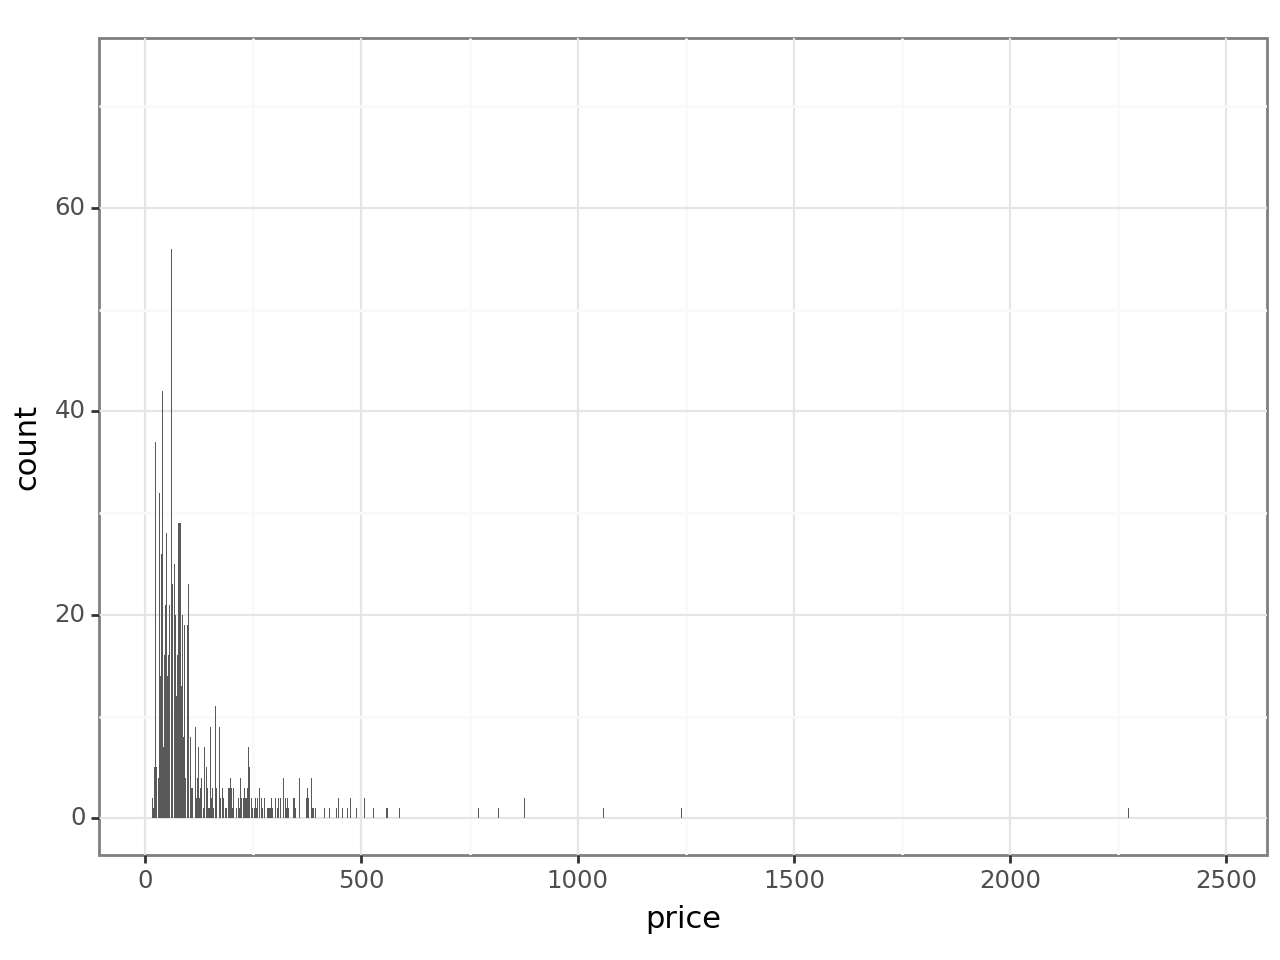

<Figure Size: (640 x 480)>

In [25]:
# crate EDA report with plotnine
from plotnine import *
(ggplot(merged_hotel_data_moscow)
 + aes('price')
 + geom_bar()
 + theme_bw()
)

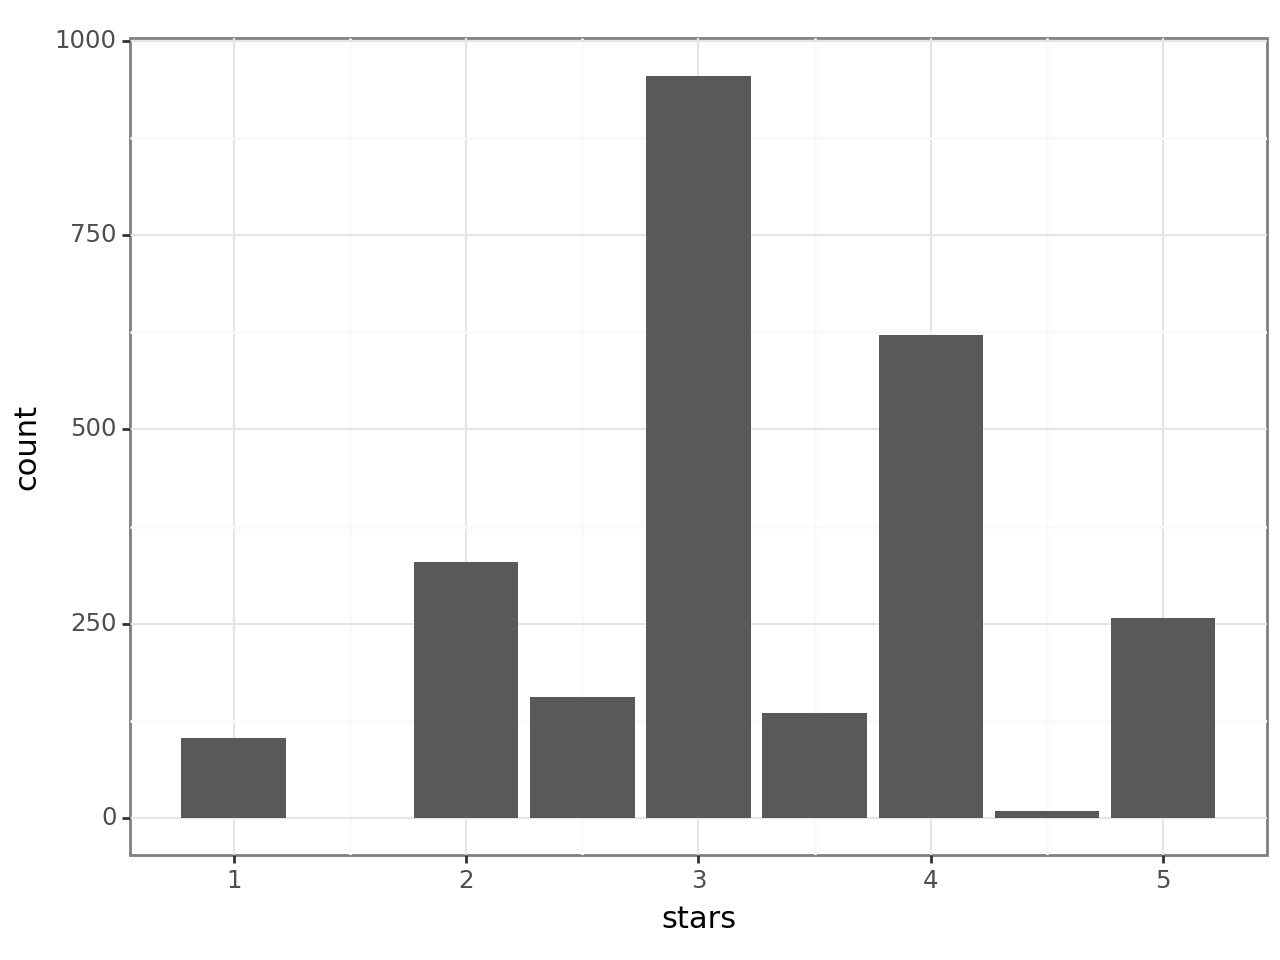

<Figure Size: (640 x 480)>

In [26]:
# crate EDA report with plotnine
from plotnine import *
(ggplot(merged_hotel_data_moscow)
 + aes('stars')
 + geom_bar()
 + theme_bw()
)

### Distance Distribution

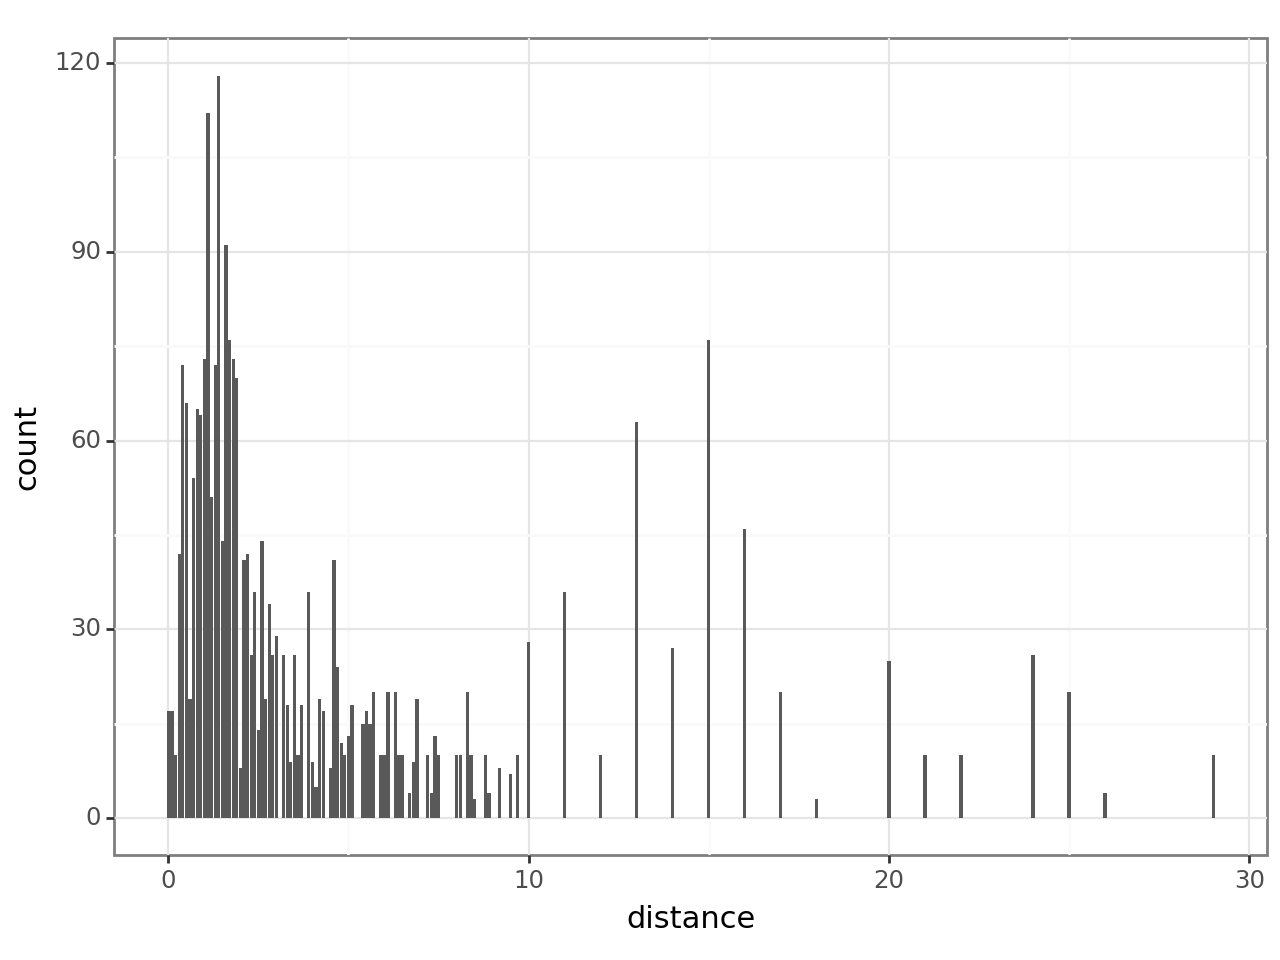

<Figure Size: (640 x 480)>

In [27]:
# crate EDA report with plotnine
from plotnine import *
(ggplot(merged_hotel_data_moscow)
 + aes('distance')
 + geom_bar()
 + theme_bw()
)

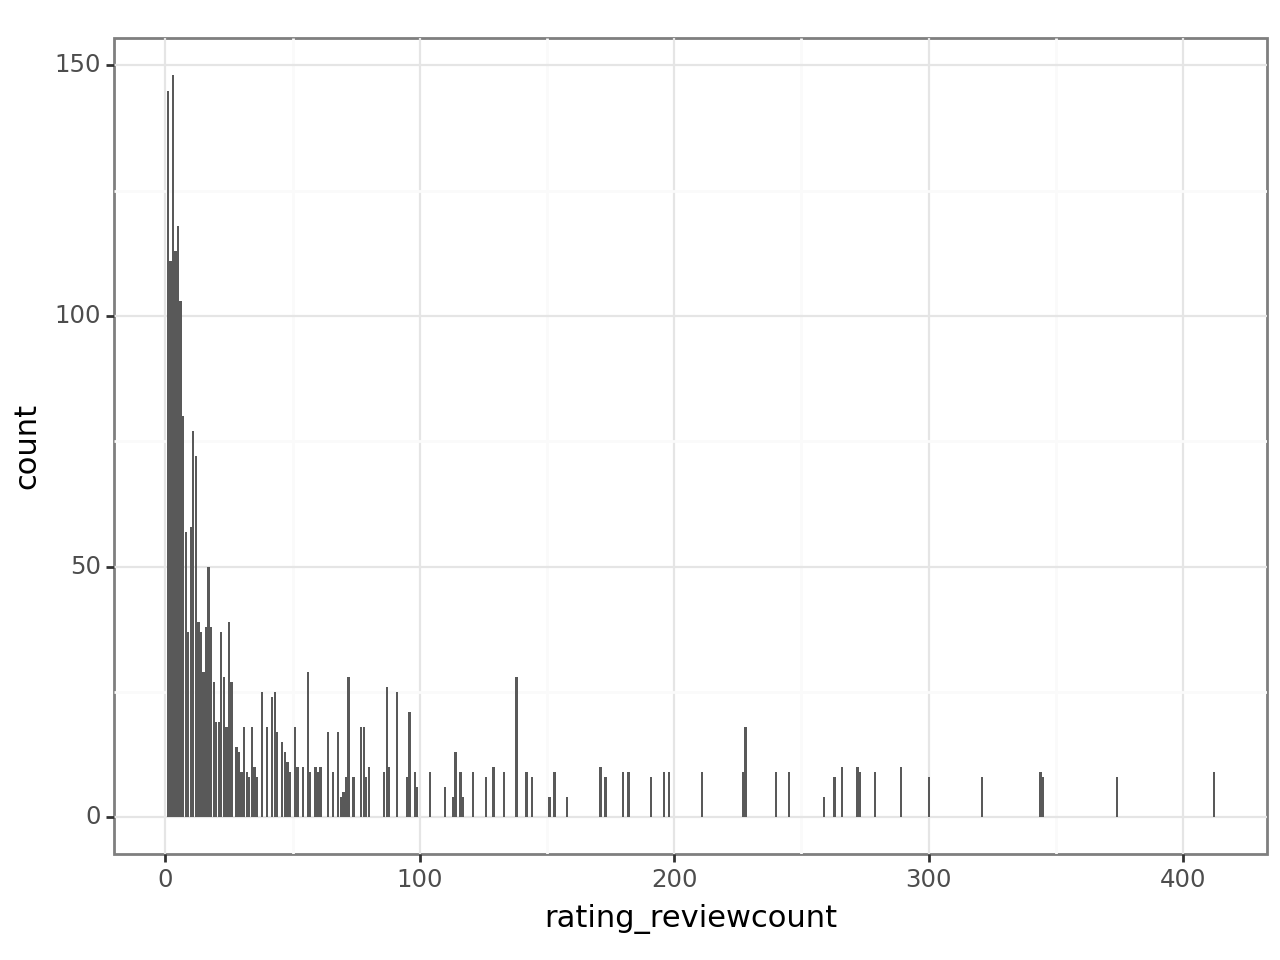

<Figure Size: (640 x 480)>

In [28]:
# crate EDA report with plotnine
from plotnine import *
(ggplot(merged_hotel_data_moscow)
 + aes('rating_reviewcount')
 + geom_bar()
 + theme_bw()
)

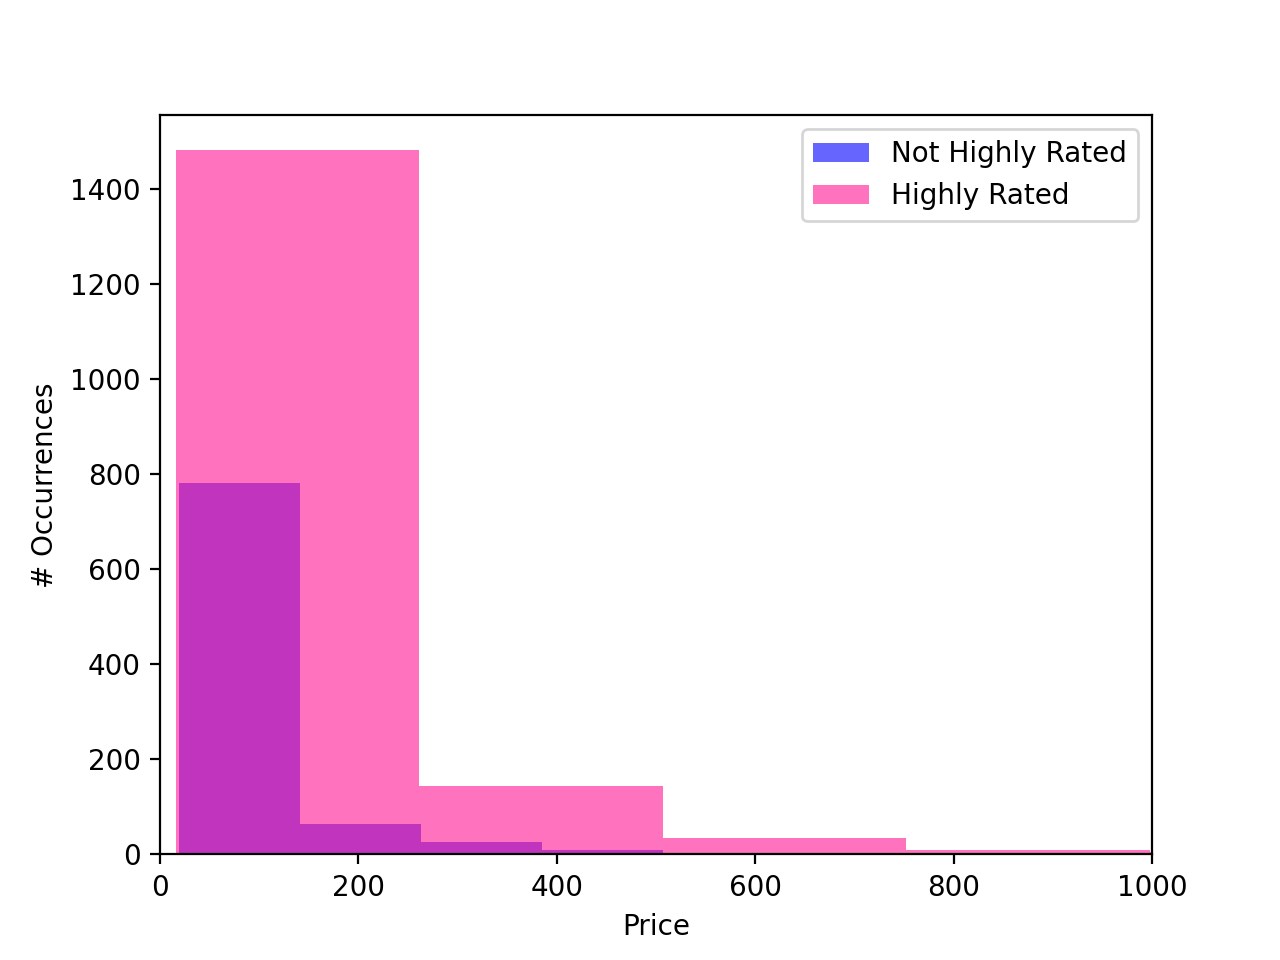

In [254]:
plt.hist(merged_hotel_data_moscow[merged_hotel_data_moscow["highly_rated"] == 0]["price"].reset_index(drop=True), alpha=0.6, label="Not Highly Rated", color="blue")
plt.hist(merged_hotel_data_moscow[merged_hotel_data_moscow["highly_rated"] == 1]["price"].reset_index(drop=True), alpha=0.6, label="Highly Rated", color="deeppink")

plt.xlabel("Price")
plt.ylabel("# Occurrences")
plt.legend()

# Set the upper limit of the x-axis to 1000
plt.xlim(0, 1000)

plt.show()


In [255]:
merged_hotel_data_moscow.loc[:, ["price", "highly_rated", "rating_reviewcount", "stars", "distance", "nnights"]].describe()

,price,highly_rated,rating_reviewcount,stars,distance,nnights
count,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000
mean,120.265004,0.655105,49.950896,3.235776,4.810171,1.344895
std,153.647841,0.475427,74.871778,0.956022,5.710563,0.957125
min,16.000000,0.000000,1.000000,1.000000,0.000000,1.000000
25%,50.000000,0.000000,6.000000,3.000000,1.200000,1.000000
50%,73.000000,1.000000,17.000000,3.000000,2.200000,1.000000
75%,120.000000,1.000000,61.000000,4.000000,6.000000,1.000000
max,2471.000000,1.000000,412.000000,5.000000,29.000000,4.000000


In [268]:
reg1 = smf.ols(formula="price~highly_rated", data=merged_hotel_data_moscow).fit(cov_type="HC1")
reg1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     112.7
Date:                Mon, 27 Nov 2023   Prob (F-statistic):           8.57e-26
Time:                        17:07:59   Log-Likelihood:                -16520.
No. Observations:                2566   AIC:                         3.304e+04
Df Residuals:                    2564   BIC:                         3.306e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            83.5706      3.121     26.781      0.000      77.454      89.687
highly_rated[T.1]    56.0130      5.276     10.616      0.000      45.671      66.355
==============================================================================
Omnibus:                     2970.181   Durbin-Watson:                   1.399
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           379832.136
Skew:                           5.886   Prob(JB):                         0.00
Kurtosis:                      61.430   Cond. No.                         3.17
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [280]:
# Quartiles of the rating_reviewcount column

# Assuming merged_hotel_data_moscow is your DataFrame

# Calculate quartiles
Q1 = merged_hotel_data_moscow['distance'].quantile(0.25)
Q2 = merged_hotel_data_moscow['distance'].quantile(0.50)  # This is also the median
Q3 = merged_hotel_data_moscow['distance'].quantile(0.75)
Q95 = merged_hotel_data_moscow['distance'].quantile(0.95)
print(f"First Quartile (Q1): {Q1}")
print(f"Second Quartile (Q2, Median): {Q2}")
print(f"Third Quartile (Q3): {Q3}")
print(f"95th: {Q95}")

First Quartile (Q1): 1.2
Second Quartile (Q2, Median): 2.2
Third Quartile (Q3): 6.0
95th: 16.0


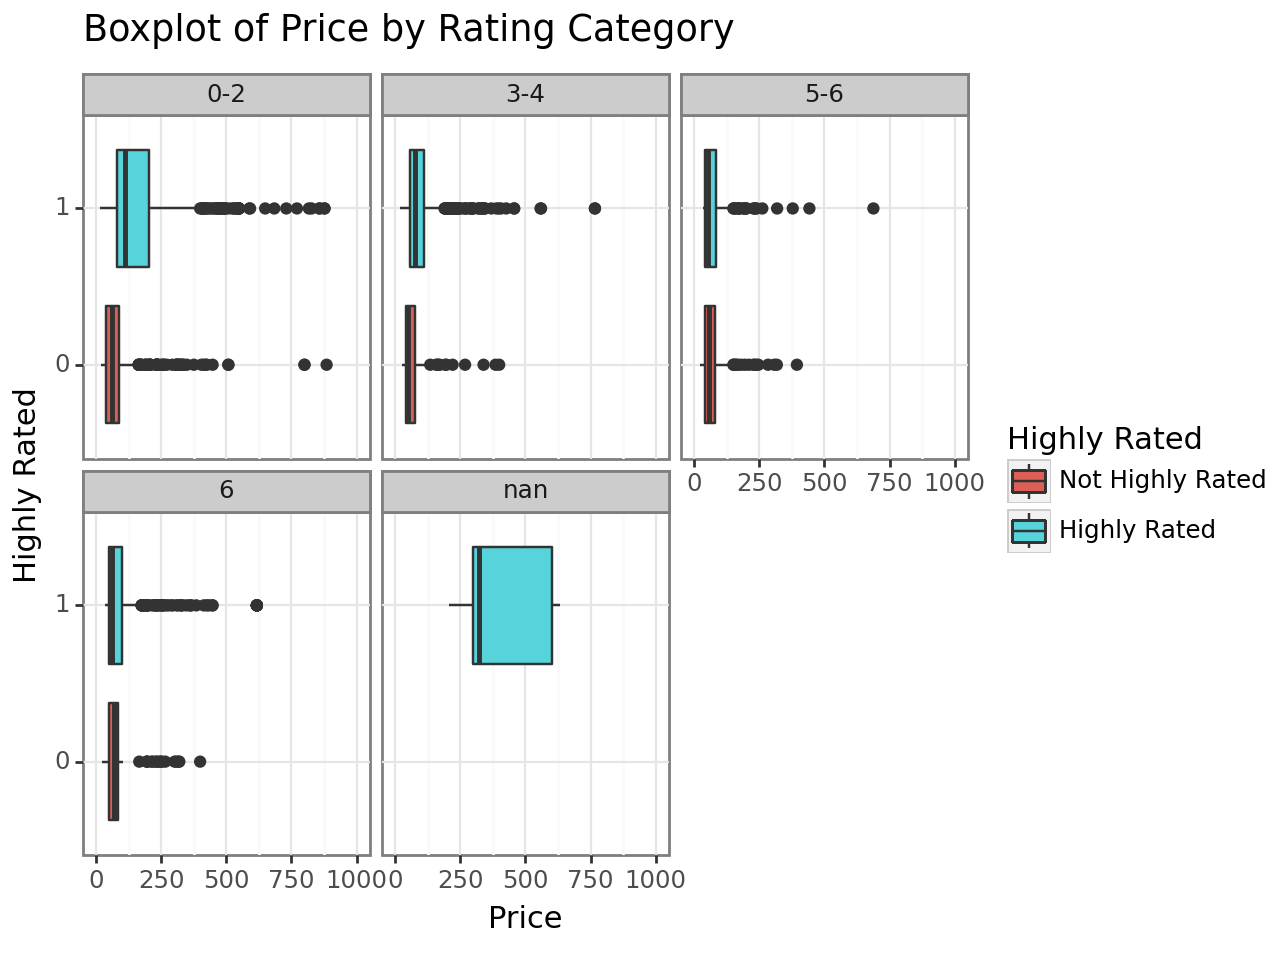

<Figure Size: (640 x 480)>

In [277]:
# Ensure 'highly_rated' is a categorical variable
merged_hotel_data_moscow['highly_rated'] = merged_hotel_data_moscow['highly_rated'].astype('category')

# Bin 'distance' and convert to categorical
merged_hotel_data_moscow['distance_category'] = pd.cut(merged_hotel_data_moscow['distance'], bins=[0, 2, 4, 6, np.inf], labels=['0-2', '3-4', '5-6', '6'])
merged_hotel_data_moscow['distance_category'] = merged_hotel_data_moscow['distance_category'].astype('category')

# Plot
(
    ggplot(data=merged_hotel_data_moscow) +
    aes(x="highly_rated", y="price", fill="highly_rated") +
    geom_boxplot() +
    coord_flip() +  # This swaps the x and y axes
    facet_wrap("~distance_category") +
    theme_bw() +
    scale_fill_discrete(labels=["Not Highly Rated", "Highly Rated"]) +
    labs(title="Boxplot of Price by Rating Category", x="Highly Rated", y="Price", fill="Highly Rated") +
    scale_y_continuous(limits=(0, 1000))  # Set limit on the y-axis, which is now displaying the 'price'
)


In [270]:
# Quartiles of the rating_reviewcount column

# Assuming merged_hotel_data_moscow is your DataFrame

# Calculate quartiles
Q1 = merged_hotel_data_moscow['rating_reviewcount'].quantile(0.25)
Q2 = merged_hotel_data_moscow['rating_reviewcount'].quantile(0.50)  # This is also the median
Q3 = merged_hotel_data_moscow['rating_reviewcount'].quantile(0.75)
Q99 = merged_hotel_data_moscow['rating_reviewcount'].quantile(0.99)
print(f"First Quartile (Q1): {Q1}")
print(f"Second Quartile (Q2, Median): {Q2}")
print(f"Third Quartile (Q3): {Q3}")
print(f"99th: {Q99}")

First Quartile (Q1): 6.0
Second Quartile (Q2, Median): 17.0
Third Quartile (Q3): 61.0
99th: 344.0


C:\Users\iandr\anaconda3\Lib\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_boxplot : Removed 13 rows containing non-finite values.


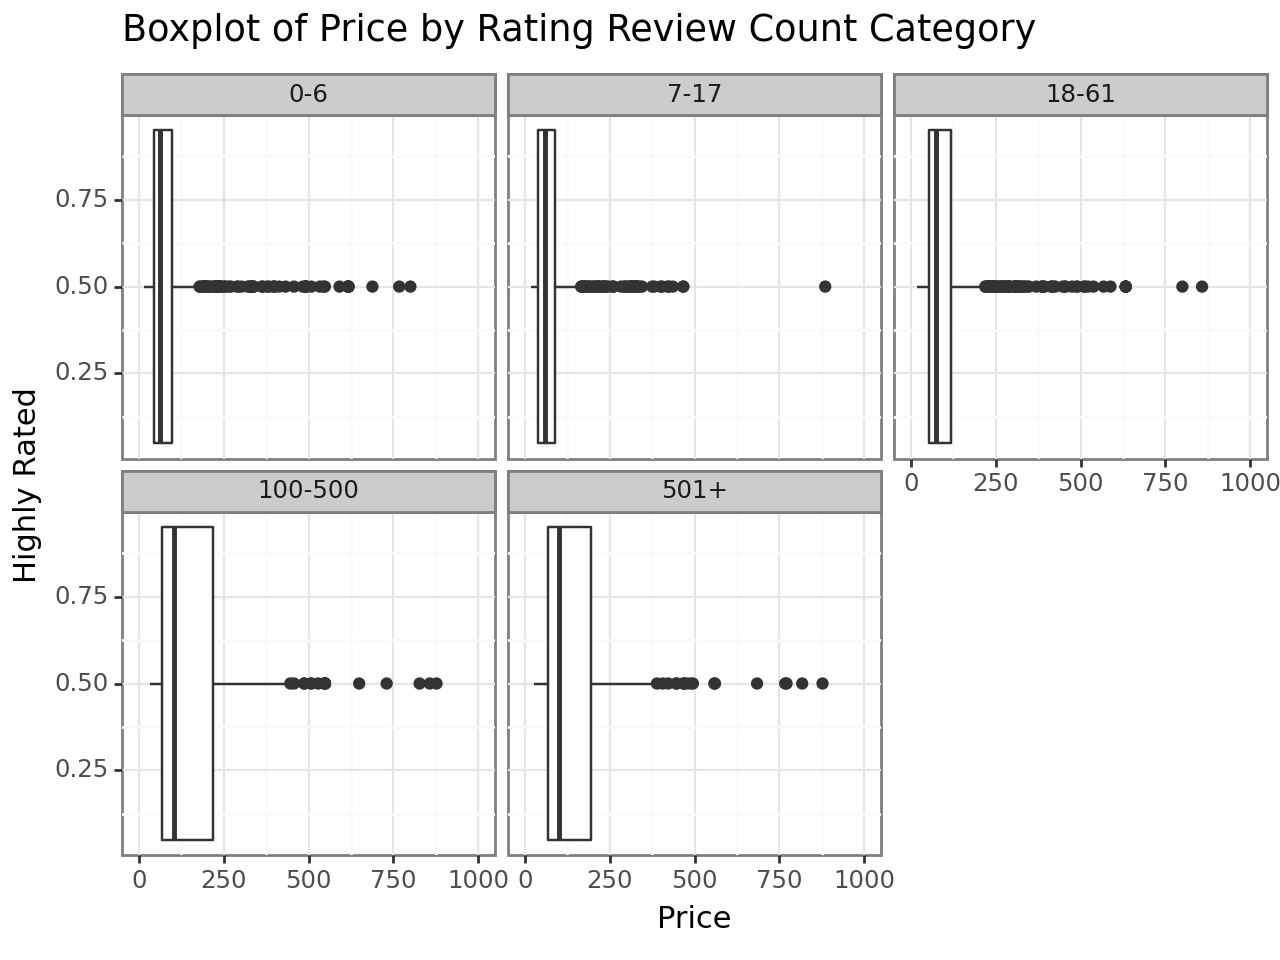

<Figure Size: (640 x 480)>

In [30]:
# Create bins for 'rating_reviewcount'
bins = [0, 6, 17, 61, 100, np.inf]  # Adjust bins as needed
labels = ['0-6', '7-17', '18-61', '100-500', '501+']
merged_hotel_data_moscow['rating_reviewcount_category'] = pd.cut(merged_hotel_data_moscow['rating_reviewcount'], bins=bins, labels=labels)

# Plot
(
    ggplot(data=merged_hotel_data_moscow) +
    aes(x="highly_rated", y="price", fill="highly_rated") +
    geom_boxplot() +
    coord_flip() +  # This swaps the x and y axes
    facet_wrap("~rating_reviewcount_category") +  # Use the binned category for faceting
    theme_bw() +
    scale_fill_discrete(labels=["Not Highly Rated", "Highly Rated"]) +
    labs(title="Boxplot of Price by Rating Review Count Category", x="Highly Rated", y="Price", fill="Highly Rated") +
    scale_y_continuous(limits=(0, 1000))  # Set limit on the y-axis, which is now displaying the 'price'
)

# Part 2

### **Estimate with distance and stars as explanatory variables**:
- linear probability models
- logit models
- probit models

*You may add other variables if you wish*.

### **Compare**:
- Coefficients
- Marginal differences
- Predicted probabilities

Discuss your results!

### Linear Probability Models

In [32]:
lpm1 = smf.ols(
    "highly_rated ~ price + nnights + stars + rating_reviewcount + distance + holiday + offer",
    merged_hotel_data_moscow,
).fit(covtype="HC1")


In [34]:
stargazer = Stargazer([lpm1])
stargazer.covariate_order(
    [
        "price",
        "nnights",
        "stars",
        "rating_reviewcount",
        "distance",
        "holiday",
    ]
)
stargazer.rename_covariates({"Intercept": "Constant"})
stargazer.add_line("Offer indicators", ["Yes"])
stargazer


In [35]:
merged_hotel_data_moscow["pred_lpm"] = lpm1.predict()

In [36]:
merged_hotel_data_moscow["pred_lpm"].describe().round(4)

count    2566.0000
mean        0.6551
std         0.1743
min         0.2042
25%         0.5510
50%         0.6295
75%         0.7607
max         1.5064
Name: pred_lpm, dtype: float64

C:\Users\iandr\anaconda3\Lib\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_bin : Removed 67 rows containing non-finite values.
C:\Users\iandr\anaconda3\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_histogram : Removed 1 rows containing missing values.


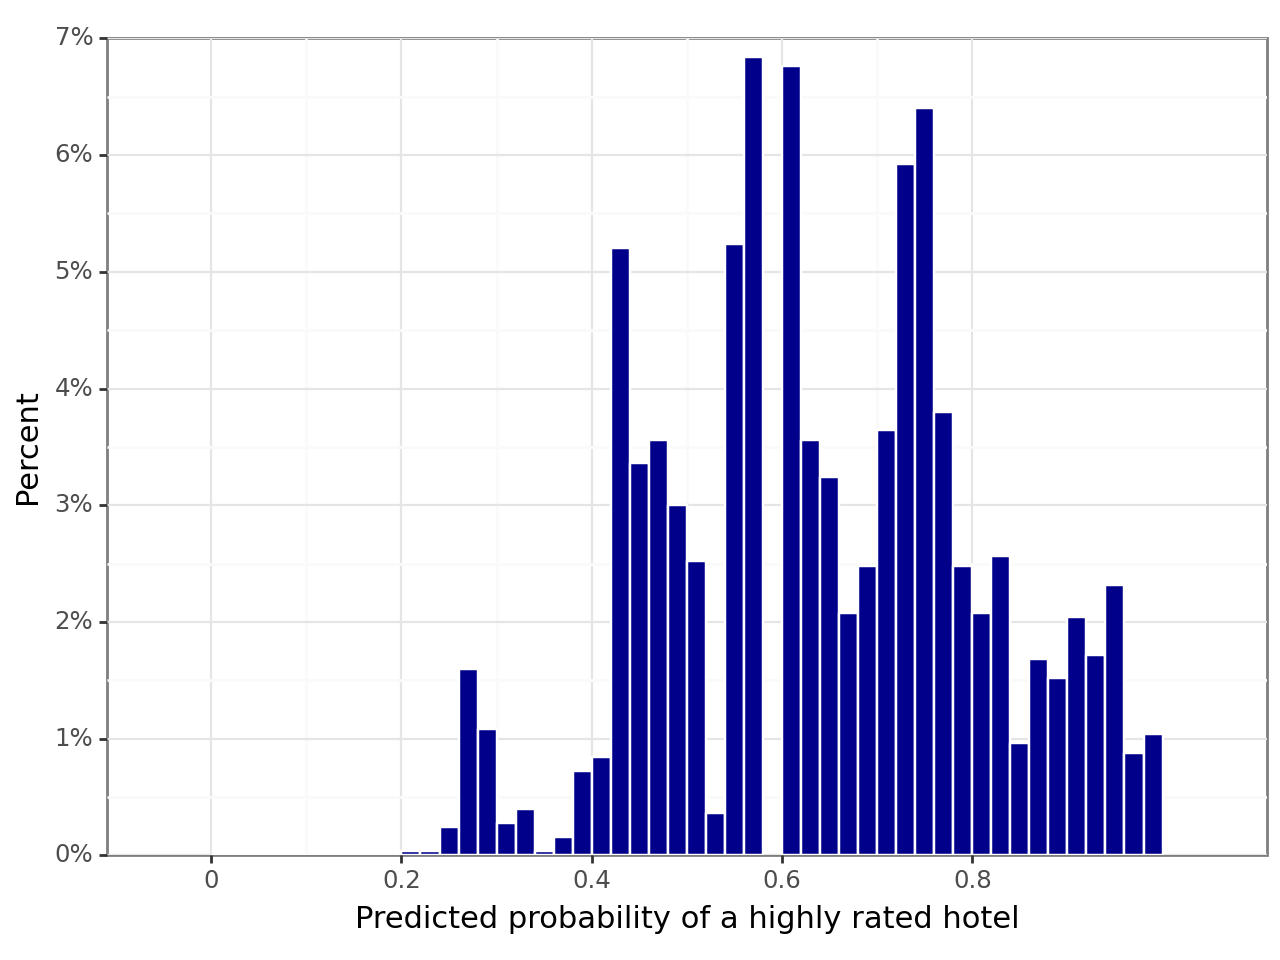

<Figure Size: (640 x 480)>

In [40]:
g1 = (
    ggplot(merged_hotel_data_moscow, aes(x="pred_lpm"))
    + geom_histogram(
        aes(y="stat(count)/sum(stat(count))"),
        binwidth=0.02,
        center=0.65,
        color="white",
        fill="darkblue",
        closed="right",
    )
    + labs(x="Predicted probability of a highly rated hotel", y="Percent")
    + scale_y_continuous(
        expand=[0.00, 0.0],
        limits=[0, 0.07],
        breaks=np.arange(0, 0.07, 0.01),
        labels=percent_format(),
    )
    + scale_x_continuous(expand=[0.1, 0.01], limits=[0, 1], breaks=np.arange(0, 1, 0.2))
    + theme_bw()
)
g1


In [42]:
cuts = 100
merged_hotel_data_moscow["q100_pred_lpm"] = pd.qcut(merged_hotel_data_moscow["pred_lpm"], q=cuts, labels=range(1, cuts + 1))

In [44]:
merged_hotel_data_moscow.loc[
    merged_hotel_data_moscow["q100_pred_lpm"] == 1,
    [
        "price",
        "nnights",
        "stars",
        "rating_reviewcount",
        "distance",
        "holiday"
    ],
].describe().round(1)

# Bottom 1%


,price,nnights,stars,rating_reviewcount,distance,holiday
count,30.0,30.0,30.0,30.0,30.0,30.0
mean,68.5,1.8,1.0,22.3,1.7,0.3
std,62.1,1.3,0.0,29.2,1.3,0.5
min,17.0,1.0,1.0,1.0,0.5,0.0
25%,28.0,1.0,1.0,1.2,0.5,0.0
50%,43.0,1.0,1.0,9.0,1.0,0.0
75%,86.8,3.2,1.0,22.0,3.3,1.0
max,241.0,4.0,1.0,80.0,3.6,1.0


In [45]:
merged_hotel_data_moscow.loc[
    merged_hotel_data_moscow["q100_pred_lpm"] == 100,
    [
        "price",
        "nnights",
        "stars",
        "rating_reviewcount",
        "distance",
        "holiday"
    ],
].describe().round(1)

# Top 1%


,price,nnights,stars,rating_reviewcount,distance,holiday
count,26.0,26.0,26.0,26.0,26.0,26.0
mean,891.3,2.3,5.0,102.9,8.3,0.5
std,640.9,1.5,0.0,108.2,7.3,0.5
min,154.0,1.0,5.0,1.0,0.0,0.0
25%,617.0,1.0,5.0,1.0,0.6,0.0
50%,692.0,1.0,5.0,70.0,14.0,0.0
75%,1175.0,4.0,5.0,196.0,14.0,1.0
max,2471.0,4.0,5.0,412.0,16.0,1.0


### Logit and Probit Models

In [47]:
from patsy import dmatrices
y, X = dmatrices(
    "highly_rated ~ price + nnights + stars + rating_reviewcount + distance + holiday + offer",
    merged_hotel_data_moscow,
)

logit = sm.GLM(y, X, family=sm.families.Binomial(link=sm.genmod.families.links.logit()))
logit = logit.fit()


C:\Users\iandr\anaconda3\Lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The logit link alias is deprecated. Use Logit instead. The logit link alias will be removed after the 0.15.0 release.


In [48]:
logit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           highly_rated   No. Observations:                 2566
Model:                            GLM   Df Residuals:                     2558
Model Family:                Binomial   Df Model:                            7
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1453.5
Date:                Tue, 28 Nov 2023   Deviance:                       2906.9
Time:                        15:14:40   Pearson chi2:                 4.37e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1441
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -1.5448      0.200     -7.729      0.000      -1.937      -1.153
price                  0.0051      0.001      5.463      0.000       0.003       0.007
nnights               -0.3526      0.087     -4.063      0.000      -0.523      -0.183
stars                  0.5799      0.070      8.254      0.000       0.442       0.718
rating_reviewcount     0.0025      0.001      3.001      0.003       0.001       0.004
distance               0.0535      0.009      5.652      0.000       0.035       0.072
holiday                0.0483      0.140      0.344      0.731      -0.227       0.324
offer                 -0.0823      0.103     -0.802      0.423      -0.283       0.119
======================================================================================
"""

In [49]:
merged_hotel_data_moscow["pred_logit"] = logit.predict()

In [50]:
merged_hotel_data_moscow["pred_logit"].describe()

count    2566.000000
mean        0.655105
std         0.179725
min         0.142417
25%         0.538252
50%         0.656124
75%         0.789380
max         0.999998
Name: pred_logit, dtype: float64

In [51]:
logit = sm.Logit(y, X)

In [55]:
logit_result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.566435
         Iterations 7


In [56]:
logit_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           highly_rated   No. Observations:                 2566
Model:                          Logit   Df Residuals:                     2558
Method:                           MLE   Df Model:                            7
Date:                Tue, 28 Nov 2023   Pseudo R-squ.:                  0.1208
Time:                        15:16:00   Log-Likelihood:                -1453.5
converged:                       True   LL-Null:                       -1653.1
Covariance Type:            nonrobust   LLR p-value:                 3.473e-82
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -1.5448      0.200     -7.729      0.000      -1.937      -1.153
price                  0.0051      0.001      5.463      0.000       0.003       0.007
nnights               -0.3526      0.087     -4.063      0.000      -0.523      -0.183
stars                  0.5799      0.070      8.254      0.000       0.442       0.718
rating_reviewcount     0.0025      0.001      3.001      0.003       0.001       0.004
distance               0.0535      0.009      5.652      0.000       0.035       0.072
holiday                0.0483      0.140      0.344      0.731      -0.227       0.324
offer                 -0.0823      0.103     -0.802      0.423      -0.283       0.119
======================================================================================
"""

In [58]:
logit_margef_results = logit_result.get_margeff()

In [59]:
logit_margef_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:           highly_rated
Method:                          dydx
At:                           overall
======================================================================================
                        dy/dx    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
price                  0.0010      0.000      5.547      0.000       0.001       0.001
nnights               -0.0683      0.017     -4.100      0.000      -0.101      -0.036
stars                  0.1123      0.013      8.723      0.000       0.087       0.138
rating_reviewcount     0.0005      0.000      3.015      0.003       0.000       0.001
distance               0.0104      0.002      5.775      0.000       0.007       0.014
holiday                0.0094      0.027      0.344      0.731      -0.044       0.063
offer                 -0.0159      0.020     -0.802      0.423      -0.055       0.023
======================================================================================
"""

In [60]:
probit = sm.Probit(y, X)


In [61]:
probit_result = probit.fit()


Optimization terminated successfully.
         Current function value: 0.568409
         Iterations 6


In [62]:
probit_result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:           highly_rated   No. Observations:                 2566
Model:                         Probit   Df Residuals:                     2558
Method:                           MLE   Df Model:                            7
Date:                Tue, 28 Nov 2023   Pseudo R-squ.:                  0.1177
Time:                        15:17:36   Log-Likelihood:                -1458.5
converged:                       True   LL-Null:                       -1653.1
Covariance Type:            nonrobust   LLR p-value:                 5.161e-80
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.9834      0.117     -8.427      0.000      -1.212      -0.755
price                  0.0020      0.000      4.989      0.000       0.001       0.003
nnights               -0.1516      0.047     -3.221      0.001      -0.244      -0.059
stars                  0.3835      0.040      9.662      0.000       0.306       0.461
rating_reviewcount     0.0015      0.000      3.147      0.002       0.001       0.002
distance               0.0272      0.005      5.249      0.000       0.017       0.037
holiday                0.0269      0.084      0.318      0.750      -0.139       0.192
offer                 -0.0661      0.061     -1.088      0.276      -0.185       0.053
======================================================================================
"""

In [63]:
merged_hotel_data_moscow["pred_probit"] = probit_result.predict()


In [64]:
merged_hotel_data_moscow["pred_probit"].describe()


count    2566.000000
mean        0.655346
std         0.174682
min         0.160314
25%         0.547202
50%         0.649092
75%         0.779079
max         1.000000
Name: pred_probit, dtype: float64

In [65]:
probit_margef_results = probit_result.get_margeff()


In [66]:
probit_margef_results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
       Probit Marginal Effects       
=====================================
Dep. Variable:           highly_rated
Method:                          dydx
At:                           overall
======================================================================================
                        dy/dx    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
price                  0.0007      0.000      5.012      0.000       0.000       0.001
nnights               -0.0491      0.015     -3.230      0.001      -0.079      -0.019
stars                  0.1243      0.012     10.298      0.000       0.101       0.148
rating_reviewcount     0.0005      0.000      3.162      0.002       0.000       0.001
distance               0.0088      0.002      5.307      0.000       0.006       0.012
holiday                0.0087      0.027      0.318      0.750      -0.045       0.062
offer                 -0.0214      0.020     -1.089      0.276      -0.060       0.017
======================================================================================
"""

In [68]:
df_plot = pd.melt(
    merged_hotel_data_moscow[["pred_lpm", "pred_logit", "pred_probit"]].rename(
        columns={"pred_logit": "Logit", "pred_probit": "Probit"}
    ),
    value_vars=["Logit", "Probit"],
    id_vars=["pred_lpm"],
).sort_values(by=["variable"], ascending=False)

C:\Users\iandr\anaconda3\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_point : Removed 134 rows containing missing values.


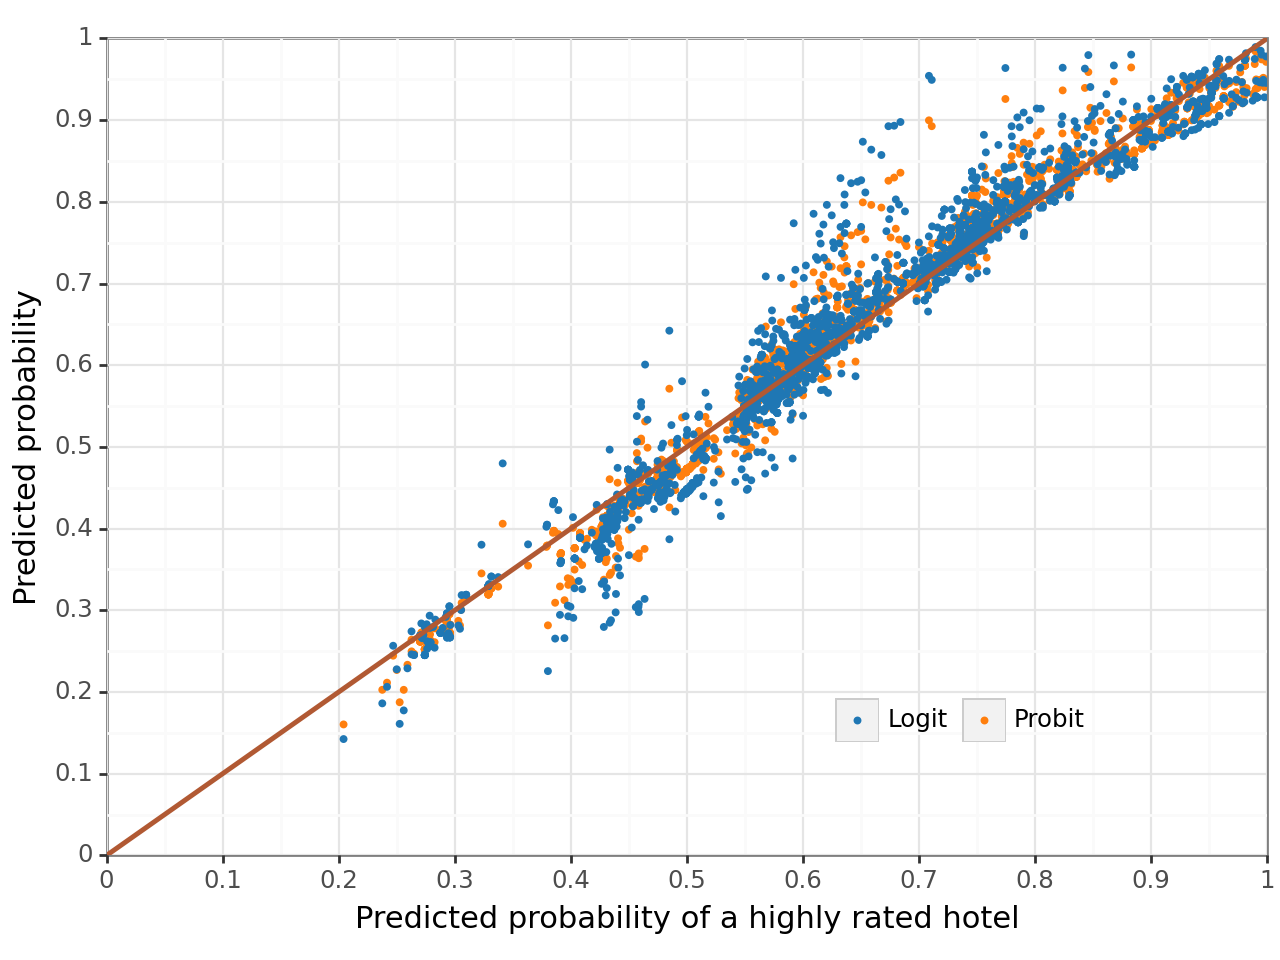

<Figure Size: (640 x 480)>

In [71]:
color = ["#1f77b4", "#ff7f0e", "#b15933"]

g2 = (
    ggplot(df_plot, aes(x="pred_lpm", y="value", color="variable"))
    + geom_point(size=0.6)
    + geom_abline(color=color[2], intercept=0, slope=1, size=1)
    + labs(
        x="Predicted probability of a highly rated hotel", y="Predicted probability"
    )
    + scale_y_continuous(expand=[0.00, 0.0], limits=[0, 1], breaks=np.arange(0, 1.1, 0.1))
    + scale_x_continuous(expand=[0.00, 0.0], limits=[0, 1], breaks=np.arange(0, 1.1, 0.1))
    + scale_color_manual(values=[color[0], color[1]])
    + theme_bw()
    + theme(
        legend_title=element_blank(),
        legend_direction="horizontal",
        legend_position=(0.75, 0.25),
        legend_background=element_blank(),
    )
)
g2